In [2]:
from pandas_datareader import data as pdr
from yahoo_fin import stock_info as si
import yfinance as yf
import pandas as pd
import datetime
import time
import talib
from talib import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost as xgb
import math
import numpy as np
from sklearn.decomposition import PCA
import pickle
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'
yf.pdr_override()

In [3]:
from LSSVMRegression import LSSVMRegression

In [4]:
def add_indicators():
        
    R_S_I = RSI(df['Adj Close'], timeperiod=slow)
    E_M_A = EMA(df['Adj Close'], timeperiod=fast)
    macd, macdsig, macdhist = MACD(df['Adj Close'], fastperiod=fast, slowperiod=slow, signalperiod=really_fast)
    mfi = MFI(df['High'], df['Low'], df['Adj Close'],df['Volume'],timeperiod=fast)
    slowk, slowd = STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=fast, slowk_period=slow, slowk_matype=0, slowd_period=slow, slowd_matype=0)
    
    #
    #
    #
    
    df['ema'] = E_M_A
    df['rsi'] = R_S_I
    df['macd'] = macd
    df['macdsig'] = macdsig
    df['macdhist'] = macdhist
    df['mfi'] = mfi
    df['slowK'] = slowk
    df['slowD'] = slowd
    
    
    
    ####
    
    

    #76 vars

    #are_all_zero = (test_TA == 0).all()
    #true if all values are 0
    #false if contain a non 0'''

    df.drop(['Close'], axis =1, inplace = True)

    

In [5]:
def add_lag(num_lag_cols, this_df):
    
    tic = time.perf_counter()
    
    '''df['ema'] = E_M_A
    df['rsi'] = R_S_I
    df['macd'] = macd
    df['macdsig'] = macdsig
    df['macdhist'] = macdhist
    df['mfi'] = mfi
    df['slowK'] = slowk
    df['slowD'] = slowd'''
    
    lag_cols = ['open',
                 'high',
                 'low',
                 'adj_close',
                 'volume',
                 'ema',
                 'rsi',
                 'macd',
                 'macdsig',
                 'macdhist',
                 'mfi',
                 'slowk',
                 'slowd']

    shift_range = [x+1 for x in range(num_lag_cols)]

    for shift in shift_range:
        train_shift = this_df[merging_keys + lag_cols].copy()

        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift

        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        this_df = pd.merge(this_df, train_shift, on=merging_keys, how='left') #.fillna(0)

    del train_shift
    
    toc = time.perf_counter()

    tic_toc = (toc - tic) / 60

    print(f"completed lagging in {tic_toc:0.4f} min")
    

    return this_df

In [6]:
def add_scale(num_interval_lag):

    cols_to_scale = ['open',#
                     'high',#
                     'low',#
                     'adj_close',#
                     'volume',#
                     'ema',#
                     'rsi',#
                     'macd',#
                     'macdsig',#
                     'macdhist',#
                     'mfi',#
                     'slowk',#
                     'slowd']#
                    

    for i in range(1,num_interval_lag+1):
        cols_to_scale.append("ema_lag_"+str(i))
        cols_to_scale.append("slowk_lag_"+str(i))
        cols_to_scale.append("slowd_lag_"+str(i))
        cols_to_scale.append("rsi_lag_"+str(i))

        cols_to_scale.append("volume_lag_"+str(i))

        cols_to_scale.append("adj_close_lag_"+str(i))
        
        cols_to_scale.append("open_lag_"+str(i))
        cols_to_scale.append("high_lag_"+str(i))
        cols_to_scale.append("low_lag_"+str(i))

        cols_to_scale.append("macd_lag_"+str(i))
        cols_to_scale.append("macdsig_lag_"+str(i))
        cols_to_scale.append("macdhist_lag_"+str(i))

        cols_to_scale.append("mfi_lag_"+str(i))
      
    return cols_to_scale

In [7]:
stock = 'MSFT'

start_date = datetime.datetime.now() - datetime.timedelta(days=59)

end_date = datetime.datetime.now()

df = pdr.get_data_yahoo(stock, start=start_date, end=end_date, interval = "2m", prepost = True)

#df = pdr.get_data_yahoo(stock, period = "max", interval = "1d", prepost = True)

#df.index = df.index.tz_localize(None)

'''#2 min ticker
# 30 intervals = 1 hour << OLD
# 195 intervals = trading day'''
                                            # there are more intervals that we can use / change
really_fast = 30
fast = 60
slow = 90

add_indicators()

# Convert Date column to datetime
df.reset_index(level=0, inplace=True)

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

df['order_day'] = [x for x in list(range(len(df)))]
# merging_keys


# Get difference between high and low of each day

[*********************100%***********************]  1 of 1 completed


In [8]:
col_list = df.columns.to_list()
col_list.remove('datetime')

In [9]:
col_list

['open',
 'high',
 'low',
 'adj_close',
 'volume',
 'ema',
 'rsi',
 'macd',
 'macdsig',
 'macdhist',
 'mfi',
 'slowk',
 'slowd',
 'order_day']

In [10]:
merging_keys = ['order_day']

num_interval_lag = 30

df = add_lag(num_interval_lag, df)

#df['adj_close'] = df['adj_close'].shift(30)

completed lagging in 0.0310 min


In [11]:
print(df.shape)

(15166, 405)


In [12]:
print(df.head(40))

                    datetime    open    high     low  adj_close  volume  ema  \
0  2021-01-13 19:02:00-05:00  216.56  216.60  216.50     216.60       0  NaN   
1  2021-01-13 19:04:00-05:00  216.55  216.60  216.50     216.50       0  NaN   
2  2021-01-13 19:08:00-05:00  216.50  216.65  216.50     216.65       0  NaN   
3  2021-01-13 19:10:00-05:00  216.52  216.52  216.52     216.52       0  NaN   
4  2021-01-13 19:12:00-05:00  216.79  216.79  216.56     216.64       0  NaN   
5  2021-01-13 19:16:00-05:00  216.55  216.79  216.52     216.79       0  NaN   
6  2021-01-13 19:18:00-05:00  216.79  216.79  216.52     216.79       0  NaN   
7  2021-01-13 19:20:00-05:00  216.76  216.79  216.52     216.52       0  NaN   
8  2021-01-13 19:22:00-05:00  216.79  216.79  216.64     216.64       0  NaN   
9  2021-01-13 19:24:00-05:00  216.78  216.79  216.62     216.79       0  NaN   
10 2021-01-13 19:26:00-05:00  216.79  216.79  216.54     216.79       0  NaN   
11 2021-01-13 19:28:00-05:00  216.79  21

In [13]:
window_size = 30

df['adj_close'] = df['adj_close'].shift(-window_size)



In [14]:
cols_to_rem = ['open',
                 'high',
                 'low',
                 'volume',
                 'ema',
                 'rsi',
                 'macd',
                 'macdsig',
                 'macdhist',
                 'mfi',
                 'slowk',
                 'slowd',
                 'order_day']

In [15]:
close_vals_list = df['adj_close']

In [16]:
df.drop(cols_to_rem, axis = 1, inplace = True)

In [17]:
print(df.tail(40))

                       datetime   adj_close  open_lag_1  high_lag_1  \
15126 2021-03-04 09:52:00-05:00  230.230103  227.339996  227.570007   
15127 2021-03-04 09:54:00-05:00  230.485001  227.289993  227.330002   
15128 2021-03-04 09:56:00-05:00  231.195007  227.000000  227.119995   
15129 2021-03-04 09:58:00-05:00  230.850006  226.500000  226.600006   
15130 2021-03-04 10:00:00-05:00  231.429993  226.520004  226.970001   
15131 2021-03-04 10:02:00-05:00  231.550003  226.860001  227.000000   
15132 2021-03-04 10:04:00-05:00  231.289993  226.850006  227.250000   
15133 2021-03-04 10:06:00-05:00  230.729996  226.645004  226.725006   
15134 2021-03-04 10:08:00-05:00  230.589996  226.429993  226.580002   
15135 2021-03-04 10:10:00-05:00  230.360001  226.169998  226.940002   
15136 2021-03-04 10:12:00-05:00         NaN  226.729996  226.850006   
15137 2021-03-04 10:14:00-05:00         NaN  226.500000  227.279999   
15138 2021-03-04 10:16:00-05:00         NaN  227.180206  227.500000   
15139 

In [18]:


#close_vals_list = df['adj_close']

df.fillna(0, inplace=True)

#df.fillna(0, inplace=True)

#BUY => 1, SELL => 0, HOLD => 2

num_test = int(.10*len(df))
num_train = len(df) - num_test

# Split into train, cv, and test
train = df[:num_train]
test = df[num_train:]

#print(test['datetime'].iloc[[-1]])
#print(test['test_labels'].iloc[[-1]])

train_close_vals = close_vals_list[:num_train]
test_close_vals = close_vals_list[num_train:]

#test_dates_list = test['date']
#BUY => 1, SELL => 0, HOLD => 2

In [19]:
test_dates_list = test['datetime']

In [20]:
train_dates_list = train['datetime']

In [21]:
test_adj_close_list = close_vals_list[num_train:]

In [22]:
cols_to_scale = add_scale(num_interval_lag)
#cols_to_scale.remove(cols_to_rem)

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak


In [23]:
for element in cols_to_rem:

    if element in cols_to_scale:

        cols_to_scale.remove(element)

In [24]:
from sklearn.preprocessing import Normalizer

In [25]:
#scaler = StandardScaler()

scaler = Normalizer()

scaler.fit(train[cols_to_scale])
train_scaled = scaler.transform(train[cols_to_scale])

# Convert the numpy array back into pandas dataframe

train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)

train_scaled = train_scaled[slow:]
train = train[slow:]

#scaling test dataset

#scaler_2 = StandardScaler()

#scaler_2  = MinMaxScaler(feature_range=(-1,1))
#scaler.fit(test[cols_to_scale])
test_scaled = scaler.transform(test[cols_to_scale])

# Convert the numpy array back into pandas dataframe

test_scaled = pd.DataFrame(test_scaled, columns=cols_to_scale)

features = cols_to_scale

In [26]:
features

['adj_close',
 'ema_lag_1',
 'slowk_lag_1',
 'slowd_lag_1',
 'rsi_lag_1',
 'volume_lag_1',
 'adj_close_lag_1',
 'open_lag_1',
 'high_lag_1',
 'low_lag_1',
 'macd_lag_1',
 'macdsig_lag_1',
 'macdhist_lag_1',
 'mfi_lag_1',
 'ema_lag_2',
 'slowk_lag_2',
 'slowd_lag_2',
 'rsi_lag_2',
 'volume_lag_2',
 'adj_close_lag_2',
 'open_lag_2',
 'high_lag_2',
 'low_lag_2',
 'macd_lag_2',
 'macdsig_lag_2',
 'macdhist_lag_2',
 'mfi_lag_2',
 'ema_lag_3',
 'slowk_lag_3',
 'slowd_lag_3',
 'rsi_lag_3',
 'volume_lag_3',
 'adj_close_lag_3',
 'open_lag_3',
 'high_lag_3',
 'low_lag_3',
 'macd_lag_3',
 'macdsig_lag_3',
 'macdhist_lag_3',
 'mfi_lag_3',
 'ema_lag_4',
 'slowk_lag_4',
 'slowd_lag_4',
 'rsi_lag_4',
 'volume_lag_4',
 'adj_close_lag_4',
 'open_lag_4',
 'high_lag_4',
 'low_lag_4',
 'macd_lag_4',
 'macdsig_lag_4',
 'macdhist_lag_4',
 'mfi_lag_4',
 'ema_lag_5',
 'slowk_lag_5',
 'slowd_lag_5',
 'rsi_lag_5',
 'volume_lag_5',
 'adj_close_lag_5',
 'open_lag_5',
 'high_lag_5',
 'low_lag_5',
 'macd_lag_5',
 '

In [27]:
features.remove('adj_close')

In [28]:
print('adj_close' in features)

False


In [29]:
print('adj_close' in train_scaled.columns)

True


In [30]:
#features.remove(target)

# Split into X and y
'''X_train_scaled = train_scaled[features]
y_train_scaled = train['labels']

X_test_scaled = test_scaled[features]
y_test_scaled = test['labels']'''

X_train = train_scaled[features]
y_train = train_scaled['adj_close']

X_test = test_scaled[features]
y_test = test_scaled['adj_close']

In [31]:
import pyswarms as ps

from sklearn.metrics import mean_squared_error

In [32]:
def fitness_function(position):
    
    #print(position)
    
    #svrRegressor = SVR(kernel='rbf', gamma = position[0].all(), C = position[1].all() )
    
    clfrbf=LSSVMRegression(
        gamma=position[0].all(),       #set the gamma-hyper parameter equal to 1
        kernel='rbf', #use the linear kernel
        sigma=position[1].all(),
            )
    
    clfrbf.fit(X_train, y_train)
    
    y_train_pred = clfrbf.predict(X_train)
    
    y_test_pred = clfrbf.predict(X_test)
    
    mse_test =mean_squared_error(y_test, y_test_pred)
    
    rmse_test = math.sqrt(mse_test)
    
    print('Optimizing the Parameters ..... C = {c}, Gamma={gamma}'.format(c=position[1], gamma=position[0]))
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    
    rmse_train = math.sqrt(mse_train)
    
    #list(range(mse_f_train,rmse_f_train))
    retVal= rmse_test #Return a vector instead of single value. you can use the rmse_test and ignore rmse_train
    
    return retVal

In [33]:
lb = [10, 0.0001]
ub = [1000,0.1]
#mb = [100, 0.001]
bounds = (lb,ub)

options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=2,options=options, bounds = bounds)
gamma_opt, C_opt = optimizer.optimize(fitness_function, iters=50)

2021-03-01 13:20:58,757 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   2%|█▏                                                           |1/50, best_cost=0.00202

Optimizing the Parameters ..... C = [6.36581772e+02 1.03846053e-03], Gamma=[2.10309692e+02 4.26535592e-02]


pyswarms.single.global_best:   4%|██▍                                                          |2/50, best_cost=0.00202

Optimizing the Parameters ..... C = [6.12817345e+02 5.30066273e-04], Gamma=[2.10884457e+02 8.34130885e-03]


pyswarms.single.global_best:   6%|███▋                                                         |3/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.10410862e+02 2.78881569e-03], Gamma=[2.11110696e+02 7.26576701e-02]


pyswarms.single.global_best:   8%|████▉                                                        |4/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.39173571e+02 1.65865020e-04], Gamma=[2.10983738e+02 1.47738831e-02]


pyswarms.single.global_best:  10%|██████                                                       |5/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.34119627e+02 9.52347437e-02], Gamma=[2.10480737e+02 5.41596930e-02]


pyswarms.single.global_best:  12%|███████▎                                                     |6/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.07269915e+02 3.19682291e-02], Gamma=[2.09951956e+02 7.74397289e-02]


pyswarms.single.global_best:  14%|████████▌                                                    |7/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.35887960e+02 6.07878265e-02], Gamma=[2.09632880e+02 8.41882818e-02]


pyswarms.single.global_best:  16%|█████████▊                                                   |8/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.97367567e+02 7.17485640e-02], Gamma=[2.09592554e+02 6.75700637e-02]


pyswarms.single.global_best:  18%|██████████▉                                                  |9/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.37371953e+02 5.83061778e-02], Gamma=[2.09856646e+02 3.56985461e-02]


pyswarms.single.global_best:  20%|████████████                                                |10/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.54539557e+02 2.45011057e-02], Gamma=[2.10241559e+02 9.79019054e-02]


pyswarms.single.global_best:  22%|█████████████▏                                              |11/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.69332933e+02 9.64399642e-02], Gamma=[2.10622880e+02 3.40954589e-02]


pyswarms.single.global_best:  24%|██████████████▍                                             |12/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.98741668e+02 5.35654014e-02], Gamma=[2.10904503e+02 7.25966932e-02]


pyswarms.single.global_best:  26%|███████████████▌                                            |13/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.16851420e+02 9.53847749e-02], Gamma=[2.10972332e+02 9.21347819e-02]


pyswarms.single.global_best:  28%|████████████████▊                                           |14/50, best_cost=0.00202

Optimizing the Parameters ..... C = [3.86170787e+02 2.55511972e-02], Gamma=[2.10786053e+02 8.06474221e-02]


pyswarms.single.global_best:  30%|██████████████████                                          |15/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.20197279e+02 5.50345059e-02], Gamma=[2.10529477e+02 5.92229016e-02]


pyswarms.single.global_best:  32%|███████████████████▏                                        |16/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.90328333e+02 9.11877221e-02], Gamma=[2.10242398e+02 3.01775539e-02]


pyswarms.single.global_best:  34%|████████████████████▍                                       |17/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.38894456e+02 1.59806975e-02], Gamma=[2.10035133e+02 7.61938045e-03]


pyswarms.single.global_best:  36%|█████████████████████▌                                      |18/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.53152830e+02 4.43439088e-02], Gamma=[2.10002949e+02 7.83216148e-04]


pyswarms.single.global_best:  38%|██████████████████████▊                                     |19/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.85817931e+02 6.83847465e-02], Gamma=[2.10127788e+02 2.55274768e-03]


pyswarms.single.global_best:  40%|████████████████████████                                    |20/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.17362655e+02 7.91074634e-02], Gamma=[2.10333306e+02 1.86625141e-02]


pyswarms.single.global_best:  42%|█████████████████████████▏                                  |21/50, best_cost=0.00202

Optimizing the Parameters ..... C = [3.56381928e+02 8.65119595e-02], Gamma=[2.10507389e+02 4.65022741e-02]


pyswarms.single.global_best:  44%|██████████████████████████▍                                 |22/50, best_cost=0.00202

Optimizing the Parameters ..... C = [3.73594395e+02 5.10737623e-02], Gamma=[2.10598686e+02 7.05147521e-02]


pyswarms.single.global_best:  46%|███████████████████████████▌                                |23/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.6223630e+02 1.1895943e-02], Gamma=[2.10612048e+02 8.17839815e-02]


pyswarms.single.global_best:  48%|████████████████████████████▊                               |24/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.61182399e+02 8.91886480e-02], Gamma=[2.10581845e+02 7.30357406e-02]


pyswarms.single.global_best:  50%|██████████████████████████████                              |25/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.99340131e+02 5.80952527e-02], Gamma=[2.10481248e+02 4.97771209e-02]


pyswarms.single.global_best:  52%|███████████████████████████████▏                            |26/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.28496302e+02 1.32491216e-02], Gamma=[2.10333776e+02 2.67285436e-02]


pyswarms.single.global_best:  54%|████████████████████████████████▍                           |27/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.33407996e+02 8.64820191e-02], Gamma=[2.10198367e+02 8.19481107e-03]


pyswarms.single.global_best:  56%|█████████████████████████████████▌                          |28/50, best_cost=0.00202

Optimizing the Parameters ..... C = [3.63534641e+02 3.26627363e-02], Gamma=[2.10127287e+02 5.17344423e-04]


pyswarms.single.global_best:  58%|██████████████████████████████████▊                         |29/50, best_cost=0.00202

Optimizing the Parameters ..... C = [3.31109012e+02 8.54808785e-02], Gamma=[2.10095064e+02 2.52724672e-03]


pyswarms.single.global_best:  60%|████████████████████████████████████                        |30/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.14698211e+02 1.77222534e-02], Gamma=[2.10107474e+02 1.70645452e-02]


pyswarms.single.global_best:  62%|█████████████████████████████████████▏                      |31/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.01859039e+02 6.69537774e-02], Gamma=[2.10246567e+02 3.89465126e-02]


pyswarms.single.global_best:  64%|██████████████████████████████████████▍                     |32/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.99777144e+02 9.45828567e-04], Gamma=[2.10415791e+02 5.94884401e-02]


pyswarms.single.global_best:  66%|███████████████████████████████████████▌                    |33/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.68198317e+02 6.22600239e-02], Gamma=[2.10512169e+02 6.83396387e-02]


pyswarms.single.global_best:  68%|████████████████████████████████████████▊                   |34/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.70262526e+02 3.21977508e-02], Gamma=[2.10527830e+02 7.22798601e-02]


pyswarms.single.global_best:  70%|██████████████████████████████████████████                  |35/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.33369751e+02 1.02779544e-02], Gamma=[2.10405224e+02 5.33207490e-02]


pyswarms.single.global_best:  72%|███████████████████████████████████████████▏                |36/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.12387895e+02 6.38783445e-03], Gamma=[2.10268917e+02 3.17034837e-02]


pyswarms.single.global_best:  74%|████████████████████████████████████████████▍               |37/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.50471263e+02 1.61980362e-02], Gamma=[2.10163456e+02 1.70461976e-02]


pyswarms.single.global_best:  76%|█████████████████████████████████████████████▌              |38/50, best_cost=0.00202

Optimizing the Parameters ..... C = [3.76032074e+02 3.42729019e-02], Gamma=[2.10154054e+02 1.11227537e-02]


pyswarms.single.global_best:  78%|██████████████████████████████████████████████▊             |39/50, best_cost=0.00202

Optimizing the Parameters ..... C = [3.98913067e+02 5.11573070e-02], Gamma=[2.10201343e+02 1.36514463e-02]


pyswarms.single.global_best:  80%|████████████████████████████████████████████████            |40/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.65528817e+02 7.37996034e-02], Gamma=[2.10283642e+02 3.43804349e-02]


pyswarms.single.global_best:  82%|█████████████████████████████████████████████████▏          |41/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.27596077e+02 7.79872823e-02], Gamma=[2.10367767e+02 5.40474635e-02]


pyswarms.single.global_best:  84%|██████████████████████████████████████████████████▍         |42/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.39541219e+02 5.48593369e-02], Gamma=[2.10427901e+02 6.77331391e-02]


pyswarms.single.global_best:  86%|███████████████████████████████████████████████████▌        |43/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.40609335e+02 2.10337140e-02], Gamma=[2.10439847e+02 7.08053114e-02]


pyswarms.single.global_best:  88%|████████████████████████████████████████████████████▊       |44/50, best_cost=0.00202

Optimizing the Parameters ..... C = [5.20774656e+02 3.57887507e-03], Gamma=[2.10433810e+02 6.13111778e-02]


pyswarms.single.global_best:  90%|██████████████████████████████████████████████████████      |45/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.46276818e+02 2.69135881e-03], Gamma=[2.10411923e+02 4.36772997e-02]


pyswarms.single.global_best:  92%|███████████████████████████████████████████████████████▏    |46/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.25090407e+02 1.22080814e-02], Gamma=[2.10362592e+02 2.74636656e-02]


pyswarms.single.global_best:  94%|████████████████████████████████████████████████████████▍   |47/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.03105598e+02 3.52994684e-02], Gamma=[2.10294572e+02 1.87024940e-02]


pyswarms.single.global_best:  96%|█████████████████████████████████████████████████████████▌  |48/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.11323142e+02 6.14244934e-02], Gamma=[2.10241714e+02 2.48471305e-02]


pyswarms.single.global_best:  98%|██████████████████████████████████████████████████████████▊ |49/50, best_cost=0.00202

Optimizing the Parameters ..... C = [4.49901941e+02 7.59750448e-02], Gamma=[2.10220285e+02 3.37522803e-02]


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|50/50, best_cost=0.00202
2021-03-01 19:32:51,987 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.002017044219685888, best pos: [2.10309692e+02 4.26535592e-02]


Optimizing the Parameters ..... C = [5.44524399e+02 7.68879726e-02], Gamma=[2.10251098e+02 4.60968166e-02]


In [34]:
print(gamma_opt)
print(C_opt)

0.002017044219685888
[2.10309692e+02 4.26535592e-02]


In [36]:
clfrbf=LSSVMRegression(
        gamma=C_opt[0],       #set the gamma-hyper parameter equal to 1
        kernel='rbf', #use the linear kernel
        sigma=C_opt[1]
            )

In [37]:
clfrbf.fit(X_train, y_train)

In [38]:
y_hat = clfrbf.predict(X_test)

In [39]:
test_scaled['adj_close'] = y_hat

inv_scaler = scaler.inverse_transform(test_scaled)

y_hat_descaled = pd.DataFrame(inv_scaler, columns = test_scaled.columns)

AttributeError: 'Normalizer' object has no attribute 'inverse_transform'

{'copy': True, 'norm': 'l2'}

In [72]:
these_params = clfrbf.get_params()

In [73]:
print(these_params)

{'c': 1.0, 'd': 2, 'gamma': 210.3096923170885, 'kernel': 'rbf', 'sigma': 0.04265355923734179}


In [43]:
import pickle
# this methodology works for saving a trained model
pickle.dump(clfrbf, open("test.model", "wb"))

AttributeError: Can't pickle local object 'LSSVMRegression.__set_kernel.<locals>.rbf'

In [49]:
import joblib as joblib
from joblib import dump
filename = "test.joblib"
joblib.dump(clfrbf, filename)

PicklingError: Can't pickle <function LSSVMRegression.__set_kernel.<locals>.rbf at 0x000001F3EE592E50>: it's not found as LSSVMRegression.LSSVMRegression.__set_kernel.<locals>.rbf

In [56]:
import dill

with open("test", "wb") as dill_file:
    dill.dump(clfrbf, dill_file)

In [62]:
this_save = dill.dumps(clfrbf) 

In [70]:
this_load = pd.read_pickle(r'test.model')

In [71]:
y_hat = this_load.predict(X_test)

AttributeError: 'bytes' object has no attribute 'predict'

In [63]:
with open("test.model", "wb") as dill_file:
    dill.dump(this_save, dill_file)

In [68]:
this_open = dill.load("test.model") 

TypeError: file must have 'read' and 'readline' attributes

In [66]:
#with open("test.model", "rb") as dill_file:
    test_clf = dill.load(this_open)

TypeError: a bytes-like object is required, not 'str'

In [26]:
y_hat

NameError: name 'y_hat' is not defined

<IPython.core.display.Javascript object>


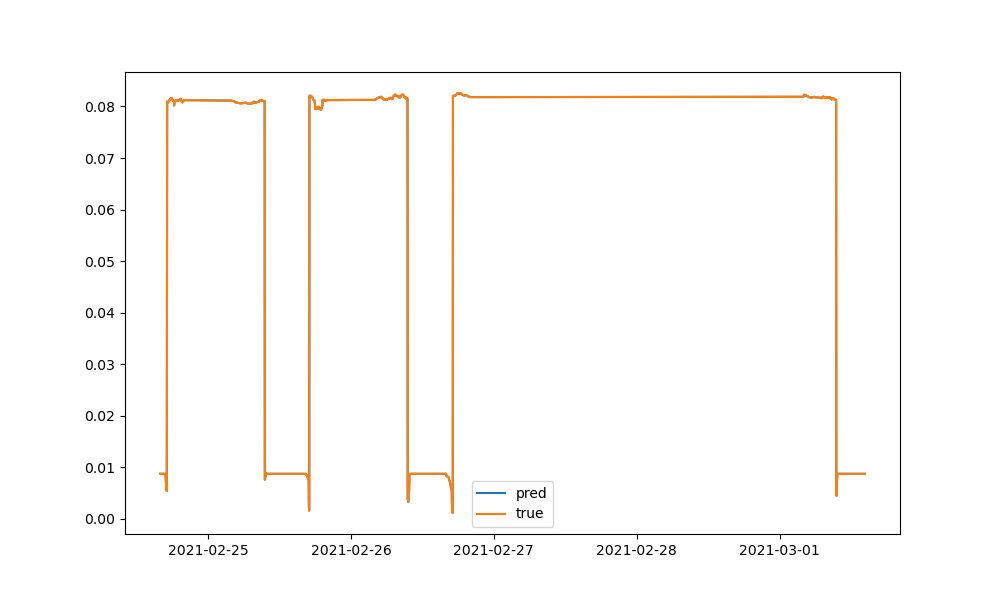

<function matplotlib.pyplot.show(block=None)>

In [41]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 6]

plt.plot(test_dates_list, y_hat)
plt.plot(test_dates_list, test_scaled['adj_close'])
plt.legend(['pred','true'])
plt.show

In [ ]:
y_hat = clfrbf.predict(X_train)

In [ ]:
train_scaled['adj_close'] = y_hat

inv_scaler = scaler.inverse_transform(train_scaled)

y_hat_descaled = pd.DataFrame(inv_scaler, columns = train_scaled.columns)

In [ ]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 6]

plt.plot(train_dates_list[slow:], y_hat_descaled['adj_close'])
plt.plot(train_dates_list[slow:], train_close_vals[slow:])
plt.legend(['pred','true'])
plt.show